In [229]:
import numpy
import pandas as pd
import pickle
import tqdm
from datetime import datetime

from easy_datetime.timestamp import TimeStamp
from data_utils.serial_utils.time_series import TimeSeries

from finance_utils.electrical2.spot.probabilistic.forecast.power.data.meteo import PFDInterFace
from finance_utils.electrical2.spot.probabilistic.forecast.power.data.tr import TRInterFace

from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore

from prophet import Prophet
from matplotlib import pyplot

In [230]:
train_ts = TRInterFace.hourly_actual_range("shanxi", "2024-10-1", "2024-10-20")
test_ts = TRInterFace.hourly_actual_range("shanxi", "2024-10-1", "2024-10-21")
train_ts

{'timestamp': [1727712000.0, 1727715600.0, 1727719200.0, 1727722800.0, 1727726400.0, 1727730000.0, 1727733600.0, 1727737200.0, 1727740800.0, 1727744400.0, 1727748000.0, 1727751600.0, 1727755200.0, 1727758800.0, 1727762400.0, 1727766000.0, 1727769600.0, 1727773200.0, 1727776800.0, 1727780400.0, 1727784000.0, 1727787600.0, 1727791200.0, 1727794800.0, 1727798400.0, 1727802000.0, 1727805600.0, 1727809200.0, 1727812800.0, 1727816400.0, 1727820000.0, 1727823600.0, 1727827200.0, 1727830800.0, 1727834400.0, 1727838000.0, 1727841600.0, 1727845200.0, 1727848800.0, 1727852400.0, 1727856000.0, 1727859600.0, 1727863200.0, 1727866800.0, 1727870400.0, 1727874000.0, 1727877600.0, 1727881200.0, 1727884800.0, 1727888400.0, 1727892000.0, 1727895600.0, 1727899200.0, 1727902800.0, 1727906400.0, 1727910000.0, 1727913600.0, 1727917200.0, 1727920800.0, 1727924400.0, 1727928000.0, 1727931600.0, 1727935200.0, 1727938800.0, 1727942400.0, 1727946000.0, 1727949600.0, 1727953200.0, 1727956800.0, 1727960400.0, 17279

In [231]:
p = ZScore.params(train_ts["power"])
train = pd.DataFrame({
    'ds':[str(TimeStamp(i)) for i in train_ts["timestamp"]],
    'y':ZScore.f(train_ts["power"])
})
train

,ds,y
0,2024-10-01 00:00:00,1.706927
1,2024-10-01 01:00:00,1.741291
2,2024-10-01 02:00:00,1.737931
3,2024-10-01 03:00:00,1.736203
4,2024-10-01 04:00:00,1.710957
...,...,...
475,2024-10-20 19:00:00,-0.700237
476,2024-10-20 20:00:00,-0.777340
477,2024-10-20 21:00:00,-0.832861
478,2024-10-20 22:00:00,-0.863399


In [232]:
model = Prophet(changepoint_prior_scale=0.1)
model.fit(train)
future = model.make_future_dataframe(periods=24, freq=f'h')
# future = model.make_future_dataframe(periods=1, freq=f'd')
forecast = model.predict(future)
forecast_ts = TimeSeries(
    timestamp = [str(i) for i in forecast[['ds']].values],
    power=forecast[['yhat']].values.reshape(-1),
    power_l=forecast[['yhat_lower']].values.reshape(-1),
    power_h=forecast[['yhat_upper']].values.reshape(-1)
)
forecast
# TimeStamp(str(forecast[['ds']].values[0]))

11:31:56 - cmdstanpy - INFO - Chain [1] start processing
11:31:56 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-10-01 00:00:00,-0.110002,-1.411724,0.333425,-0.110002,-0.110002,-0.451858,-0.451858,-0.451858,-0.466059,-0.466059,-0.466059,0.014200,0.014200,0.014200,0.0,0.0,0.0,-0.561860
1,2024-10-01 01:00:00,-0.112476,-1.351527,0.475342,-0.112476,-0.112476,-0.337426,-0.337426,-0.337426,-0.381575,-0.381575,-0.381575,0.044149,0.044149,0.044149,0.0,0.0,0.0,-0.449902
2,2024-10-01 02:00:00,-0.114950,-1.253918,0.559189,-0.114950,-0.114950,-0.249319,-0.249319,-0.249319,-0.323252,-0.323252,-0.323252,0.073933,0.073933,0.073933,0.0,0.0,0.0,-0.364269
3,2024-10-01 03:00:00,-0.117425,-1.269044,0.534119,-0.117425,-0.117425,-0.249687,-0.249687,-0.249687,-0.353037,-0.353037,-0.353037,0.103350,0.103350,0.103350,0.0,0.0,0.0,-0.367112
4,2024-10-01 04:00:00,-0.119899,-1.345930,0.535267,-0.119899,-0.119899,-0.306959,-0.306959,-0.306959,-0.439162,-0.439162,-0.439162,0.132203,0.132203,0.132203,0.0,0.0,0.0,-0.426858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2024-10-21 19:00:00,0.495398,-1.166853,0.651197,0.492729,0.498967,-0.773319,-0.773319,-0.773319,-0.642435,-0.642435,-0.642435,-0.130885,-0.130885,-0.130885,0.0,0.0,0.0,-0.277921
500,2024-10-21 20:00:00,0.497464,-1.020423,0.699270,0.494456,0.501302,-0.659928,-0.659928,-0.659928,-0.556769,-0.556769,-0.556769,-0.103159,-0.103159,-0.103159,0.0,0.0,0.0,-0.162464
501,2024-10-21 21:00:00,0.499531,-0.923767,0.862433,0.496220,0.503810,-0.569072,-0.569072,-0.569072,-0.494481,-0.494481,-0.494481,-0.074590,-0.074590,-0.074590,0.0,0.0,0.0,-0.069541
502,2024-10-21 22:00:00,0.501597,-1.012242,0.875124,0.497978,0.506280,-0.538360,-0.538360,-0.538360,-0.492986,-0.492986,-0.492986,-0.045374,-0.045374,-0.045374,0.0,0.0,0.0,-0.036763


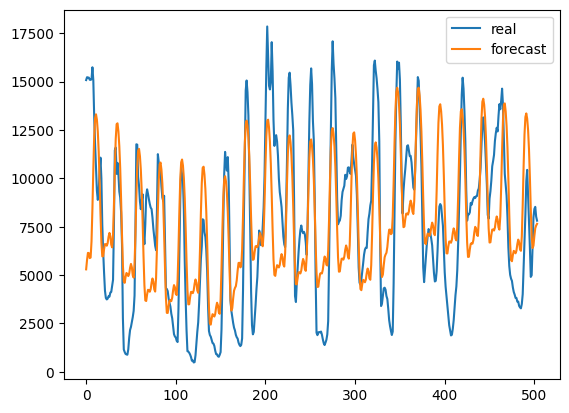

In [233]:

pyplot.plot(test_ts["power"].tolist(),label='real')
# pyplot.plot(forecast_ts["power_l"].tolist(),label='forecastL')
# pyplot.plot(forecast_ts["power_h"].tolist(),label='forecastH')
pyplot.plot(ZScore.invert(forecast_ts["power"], p).tolist(),label='forecast')
pyplot.legend()
pyplot.show()